# Week 6: Tree-based Models

## Prerequisites
+ Tree-based models (수형모델, 나무기반모델): 여러 변수들을 if-else 방식으로 양분하여 정의한 규칙(rule)들을 이용하여 예측과 분류를 수행하는 모델을 말합니다.
    + if-else 방식: 논리적으로 배반인 두 하위집합으로 변수를 나누는 방법입니다.
        + 연속형 변수라면 특정한 값을 기준으로 하여 이상(초과)/미만(이하)의 두 범위로 나누는 것입니다.
        + 범주형 변수라면 특정 범주와 나머지 범주 전체의 두 새로운 범주로 나누는 것입니다.
    + 규칙: 위의 'if-else 방식'에서, if-else 문들의 집합을 말합니다.
+ 나무 (trees): if-else로 분기(split)되는 논리적 흐름을 그림으로 나타낸 것 또는 그 논리적 표현입니다.
    + 분기를 통해 나무의 가장 마지막 부분에서 예측 또는 분류가 직접 이루어지는 부분을 종말노드(terminal nodes) 또는 이파리(leaves)라고 합니다.
    + 분기가 하나 추가될 때마다 총 종말노드 개수는 1개씩 늘어납니다. 아래 그림으로 확인해 보십시오. 부등식들이 분기이고, 그 아래 배반집합으로 나뉜 두 이파리들이 종말노드입니다. 아래 그림의 예시에서는 3개의 분기와 4개의 종말노드가 있습니다.

![그림 출처: ClearPredictions](https://clearpredictions.com/Images/Decision_Tree_Example.png)

+ 오늘 다룰 tree-based models는 Classification and Regression Trees (CART)와 Tree ensemble 입니다.
+ 자료는 지방자치단체별 인허가 데이터로, '여행업(국내/국외)' 자료를 이용하려 합니다.

In [3]:
options(warn = -1)
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(rpart))
suppressPackageStartupMessages(library(party))
suppressPackageStartupMessages(library(partykit))
suppressPackageStartupMessages(library(rpart.plot))
suppressPackageStartupMessages(library(randomForest))

In [4]:
trip.in <- read_csv('Trip_in_20180817_utf.csv', locale = locale(encoding = 'UTF-8'))
trip.out <- read_csv('Trip_out_20180817_utf.csv', locale = locale(encoding = 'UTF-8'))

Parsed with column specification:
cols(
  .default = col_character(),
  번호 = col_integer(),
  인허가일자 = col_integer(),
  폐업일자 = col_integer(),
  휴업시작일자 = col_integer(),
  휴업종료일자 = col_integer(),
  소재지우편번호 = col_integer(),
  건축연면적 = col_integer(),
  기획여행보험시작일자 = col_integer(),
  기획여행보험종료일자 = col_integer(),
  보험시작일자 = col_integer(),
  보험종료일자 = col_integer(),
  시설규모 = col_integer(),
  자본금 = col_double(),
  `위치정보(X)` = col_double(),
  `위치정보(Y)` = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  번호 = col_integer(),
  인허가일자 = col_integer(),
  폐업일자 = col_integer(),
  휴업시작일자 = col_integer(),
  휴업종료일자 = col_integer(),
  소재지우편번호 = col_integer(),
  기획여행보험시작일자 = col_integer(),
  기획여행보험종료일자 = col_integer(),
  보험시작일자 = col_integer(),
  보험종료일자 = col_integer(),
  시설규모 = col_integer(),
  자본금 = col_integer(),
  `위치정보(X)` = col_double(),
  `위치정보(Y)` = col_double()
)
See spec(...) for full column specifications.


In [4]:
head(trip.in)
colnames(trip.in)
colnames(trip.out)

번호,사업장명,소재지전체주소,도로명전체주소,인허가일자,영업상태명,폐업일자,휴업시작일자,휴업종료일자,재개업일자,⋯,영문상호명,자본금,제작취급품목내용,주변환경명,지역구분명,전화번호,위치정보(X),위치정보(Y),인허가번호,상세영업상태명
1,섬투어 주식회사,충청남도 천안시 서북구 직산읍 삼은리 356번지,충청남도 천안시 서북구 직산읍 봉주로 38,20150520,운영중,NA,NA,NA,NA,⋯,NA,3.00e+07,NA,기타,준주거지역,041-585-6666,213438.8,375349.5,CDFI2260012015000005,영업중
2,(주)삼백관광,경상북도 상주시 남성동 50번지,경상북도 상주시 남성4길 50 (남성동),20150624,운영중,NA,NA,NA,NA,⋯,NA,3.00e+07,NA,NA,NA,NA,304179.0,324330.0,CDFI2260012015000001,영업중
3,(주)트래블리퍼블릭,서울특별시 광진구 자양동 783-1번지 3층 상가동 303호,"서울특별시 광진구 아차산로36길 35, 상가동 3층 303호 (자양동)",20150629,운영중,NA,NA,NA,NA,⋯,NA,9.00e+07,NA,NA,NA,NA,206549.2,448622.1,CDFI2260012015000003,영업중
4,온새미로여행사,충청북도 영동군 황간면 우천리 158-2번지,충청북도 영동군 황간면 우천1길 50-42,20150629,운영중,NA,NA,NA,NA,⋯,Onsaemiro travel agency,NA,NA,NA,일반상업지역,NA,278561.2,304546.3,CDFI2260012015000001,영업중
5,클라우드여행사,울산광역시 동구 화정동 632-6번지,울산광역시 동구 대송로 113-2 (화정동),20150325,운영중,NA,NA,NA,NA,⋯,NA,1.08e+08,NA,주택가주변,일반주거지역,052-252-5510,419926.3,225040.3,CDFI2260012015000001,영업중
6,(주)호텔조아,경기도 부천시 중동 1142-3번지,"경기도 부천시 중동로262번길 72, 314호 (중동)",20150521,폐업 등,20160629,NA,NA,NA,⋯,NA,4.50e+07,NA,NA,NA,1577-8032,179858.0,444502.0,CDFI2260012015000003,폐업


[1] "번호"                 "사업장명"             "소재지전체주소"      
 [4] "도로명전체주소"       "인허가일자"           "영업상태명"          
 [7] "폐업일자"             "휴업시작일자"         "휴업종료일자"        
[10] "재개업일자"           "소재지면적"           "소재지우편번호"      
[13] "건물용도명"           "건축연면적"           "기획여행보험시작일자"
[16] "기획여행보험종료일자" "문화사업자구분명"     "문화체육업종명"      
[19] "보험기관명"           "보험시작일자"         "보험종료일자"        
[22] "부대시설내역"         "시설규모"             "안내소유무"          
[25] "영문상호명"           "자본금"               "제작취급품목내용"    
[28] "주변환경명"           "지역구분명"           "전화번호"            
[31] "위치정보(X)"          "위치정보(Y)"          "인허가번호"          
[34] "상세영업상태명"

[1] "번호"                 "사업장명"             "소재지전체주소"      
 [4] "도로명전체주소"       "인허가일자"           "영업상태명"          
 [7] "폐업일자"             "휴업시작일자"         "휴업종료일자"        
[10] "재개업일자"           "소재지면적"           "소재지우편번호"      
[13] "건물용도명"           "건축연면적"           "기획여행보험시작일자"
[16] "기획여행보험종료일자" "문화사업자구분명"     "문화체육업종명"      
[19] "보험기관명"           "보험시작일자"         "보험종료일자"        
[22] "부대시설내역"         "시설규모"             "안내소유무"          
[25] "영문상호명"           "자본금"               "제작취급품목내용"    
[28] "주변환경명"           "지역구분명"           "전화번호"            
[31] "위치정보(X)"          "위치정보(Y)"          "인허가번호"          
[34] "상세영업상태명"

In [5]:
trip.in <- trip.in %>% 
    mutate(class = 'Domestic')
trip.out <- trip.out %>% 
    mutate(건축연면적 = as.integer(건축연면적),
           class = 'Foreign')
trip.all <- bind_rows(trip.in, trip.out) %>%
    dplyr::select(4,5,6,7,14,23,26,31,32,35) %>%
    filter(!is.na(자본금)) %>%
    mutate(sido = stringr::str_split_fixed(도로명전체주소, ' ', 3)[,1],
           startyr = floor(인허가일자/10000),
           endyr = floor(폐업일자/10000),
           dur = if_else(is.na(endyr), 2018 - startyr, endyr - startyr),
           capital = 자본금/1e6,
           capital.big = if_else(capital > quantile(capital, 0.95), 'Upper', 'Ordinary') %>% as.factor,
           isseoul = if_else(sido == '서울특별시', 'Seoul', 'Non-Seoul') %>% as.factor,
           isclosed = if_else(grepl('^(폐업).*', 영업상태명), 'closed', 'running') %>% as.factor,
           isdomestic = factor(class))
dim(trip.all)

[1] 15685    19

In [87]:
head(trip.all)
summary(trip.all)

도로명전체주소,인허가일자,영업상태명,폐업일자,건축연면적,시설규모,자본금,위치정보(X),위치정보(Y),class,sido,startyr,endyr,dur,capital,capital.big,isseoul,isclosed,isdomestic
충청남도 천안시 서북구 직산읍 봉주로 38,20150520,운영중,NA,NA,44,3.00e+07,213438.8,375349.5,Domestic,충청남도,2015,NA,3,30,Ordinary,Non-Seoul,running,Domestic
경상북도 상주시 남성4길 50 (남성동),20150624,운영중,NA,NA,NA,3.00e+07,304179.0,324330.0,Domestic,경상북도,2015,NA,3,30,Ordinary,Non-Seoul,running,Domestic
"서울특별시 광진구 아차산로36길 35, 상가동 3층 303호 (자양동)",20150629,운영중,NA,NA,NA,9.00e+07,206549.2,448622.1,Domestic,서울특별시,2015,NA,3,90,Ordinary,Seoul,running,Domestic
울산광역시 동구 대송로 113-2 (화정동),20150325,운영중,NA,NA,46,1.08e+08,419926.3,225040.3,Domestic,울산광역시,2015,NA,3,108,Ordinary,Non-Seoul,running,Domestic
"경기도 부천시 중동로262번길 72, 314호 (중동)",20150521,폐업 등,20160629,NA,NA,4.50e+07,179858.0,444502.0,Domestic,경기도,2015,2016,1,45,Ordinary,Non-Seoul,closed,Domestic
"경기도 고양시 덕양구 화중로 96, 501-1호 (화정동, 우정프라자)",20150521,운영중,NA,NA,34,3.00e+07,185075.0,459269.0,Domestic,경기도,2015,NA,3,30,Ordinary,Non-Seoul,running,Domestic


 도로명전체주소       인허가일자        영업상태명           폐업일자       
 Length:15685       Min.   :19720424   Length:15685       Min.   :19890208  
 Class :character   1st Qu.:20051028   Class :character   1st Qu.:20081119  
 Mode  :character   Median :20100928   Mode  :character   Median :20120612  
                    Mean   :20093434                      Mean   :20115972  
                    3rd Qu.:20141202                      3rd Qu.:20150922  
                    Max.   :20180814                      Max.   :20180813  
                                                          NA's   :10907     
   건축연면적        시설규모            자본금           위치정보(X)    
 Min.   :  61.0   Min.   :     0.0   Min.   :0.000e+00   Min.   : -9201  
 1st Qu.: 493.0   1st Qu.:    33.0   1st Qu.:5.000e+07   1st Qu.:191210  
 Median : 537.0   Median :    53.0   Median :6.000e+07   Median :205296  
 Mean   : 547.6   Mean   :   206.7   Mean   :1.557e+08   Mean   :243103  
 3rd Qu.: 628.0   3rd Qu.:    91.0   3rd Qu.:1.000e

## Classification and Regression Trees (CART)
+ 분류 또는 회귀분석을 실시하기 위해 나무기반모델을 이용할 때, 우리는 이를 Classification and Regression Trees라고 통칭합니다. 이 명칭은 Breiman이라는 학자가 제안했고, 이미 1980년대에 개념화가 끝난 모형입니다.
+ 우리는 이 장에서 분류 문제만 다루게 되므로, 회귀분석트리에 대해 간단히 익혀보겠습니다.

### Regression Trees
+ 단순하게 말해서, 회귀트리란 첫 번째 그림과 같은 나무기반모델에서 __종말노드가 하나의 회귀직선이 되는 모형__을 말합니다. 단순한 값을 추정한다면 종말노드에 분류된 값은 단순히 모인 값들의 평균이 됩니다. 완성된 모형으로 예측한다면, 종말노드에서 얻는 값은 하나입니다.
+ 회귀직선에 필요한 종속변수와 독립변수가 미리 결정되어 있다면, 종말노드에서 앞서 말한 대로 하나의 회귀직선을 이룹니다. 나무를 단순하게 만들수록 (즉 가지치기 _pruning_ 할수록) 적합해야 할 모형의 개수는 줄어들게 될 것입니다.
+ 본격적인 Regression tree는 `RWeka` 패키지를 설치하면 수행해볼 수 있습니다. 대표적인 알고리즘으로 `M5P`나 `M5Rules` 등이 있습니다.

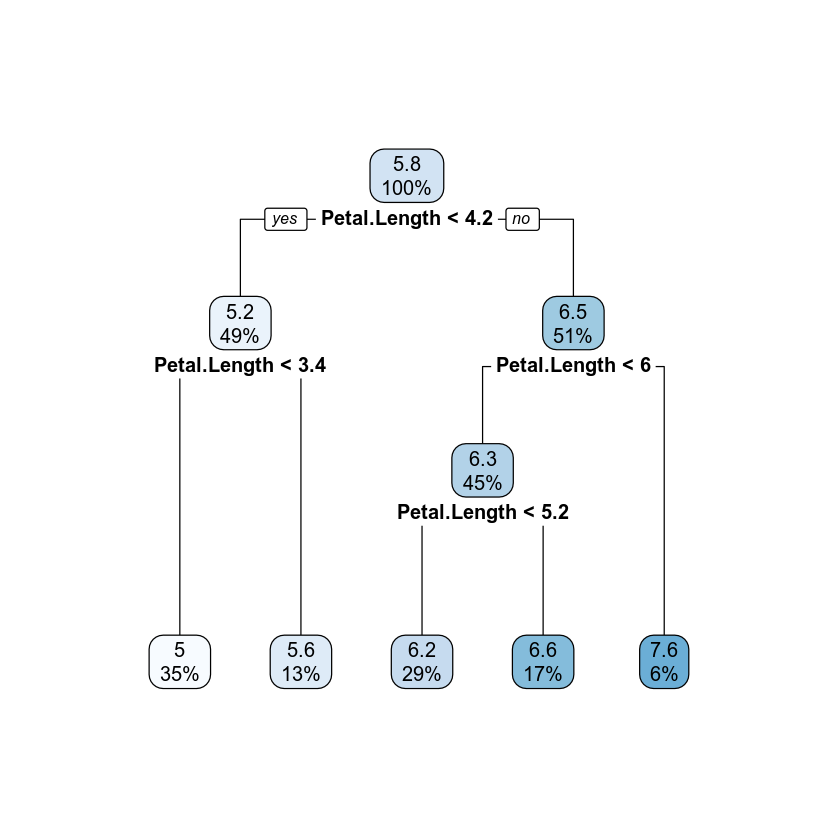

In [109]:
data(iris)
iris.rpart <- rpart(Sepal.Length ~ Petal.Length + Species, data = iris)
rpart.plot(iris.rpart)

+ 여기서 우리는 간단한 예로 자본금(연속), 존속연수(연속), 시도(범주) 등을 이용해서 모델링을 해 보려 합니다.
+ `trip.part1`에서는 자본금을 연속형 그대로 투입했고 존속연수도 마찬가지로 연도로 그대로 투입했습니다.
+ 기초적인 CART는 `rpart::rpart`로 수행합니다. `control`에 주의하십시오. `rpart.control`로 여러 가지 모델 파라미터를 조정할 수 있습니다만, 여기서는 `cp` 파라미터만 조절했습니다. `cp`는 'complexity penalty'의 준말로, 값이 더 커질수록 나무모형이 더 간단해지도록 (즉, 종말노드 수가 작아지도록) 만듭니다.
+ 아래 나온 그림 가운데 첫 번째 그림(`trip.part1`)을 해석해 봅시다. 일단, 각 상자의 중간에 있는 0과 1 사이의 숫자는 상자의 색상과 관계 없이 기준 범주, 즉 'running'이 차지하는 비율입니다. 가장 아래에 있는 %들은 총 개수 대비 비중입니다.
+ 우리가 기대하는 결과는, 각 종말노드에서 확률을 최대한 높이는 것입니다. 다만 기준 범주가 'running'이므로, running으로 표시된 노드의 확률은 높게, 'closed'로 표시된 노드의 확률은 최대한 낮게 만들고자 합니다. 
    + 세 번째 분기를 주목해 주십시오.
        + 첫 번째 옅은 푸른 빛의 상자는, 존속연수가 5년 반 미만이고 자본금이 5천만 원 미만인지의 규칙을 의미하는데, 해당 노드에서 사업체가 존속할 확률은 정확히 절반이고 이 노드에 전체 연구 대상 업체의 36%가 걸려 있습니다. 
    + 결과를 종합하여 봅시다.
        + 일단 사업체가 5년 반 이상 존속하면, 74%는 생존합니다.
        + 일단 존속연수가 5년 반도 되지 않더라도 자본금이 작은 회사는 상당히 생존하게 됩니다. 생존확률은 77%입니다.
        + 그 가운데서도 다시 초대규모 자본금을 가진 회사(자본금 1억 3천만 원 이상)가 생존하기는 상당히 어려움을 알 수 있습니다. 생존확률이 28%로 여느 노드들보다도 가장 낮습니다. 
+ 위의 데이터 정리 부분에서도 나와있다시피, 우리는 몇 가지 변수들을 모두 이진변수로 변환해 두었습니다. 특히 `capital.big` 변수는 자본금이 상위 5%인지를 구분하였습니다. 1차 모델에서 '자본금'을 연속으로 두었을 때, 31, 50, 56, 그리고 130 등이 중요한 기준으로 선택되었습니다. 이 정보를 '5%'라는 금액으로 단순화하여 모델에 반영하면 어떻게 될까요?

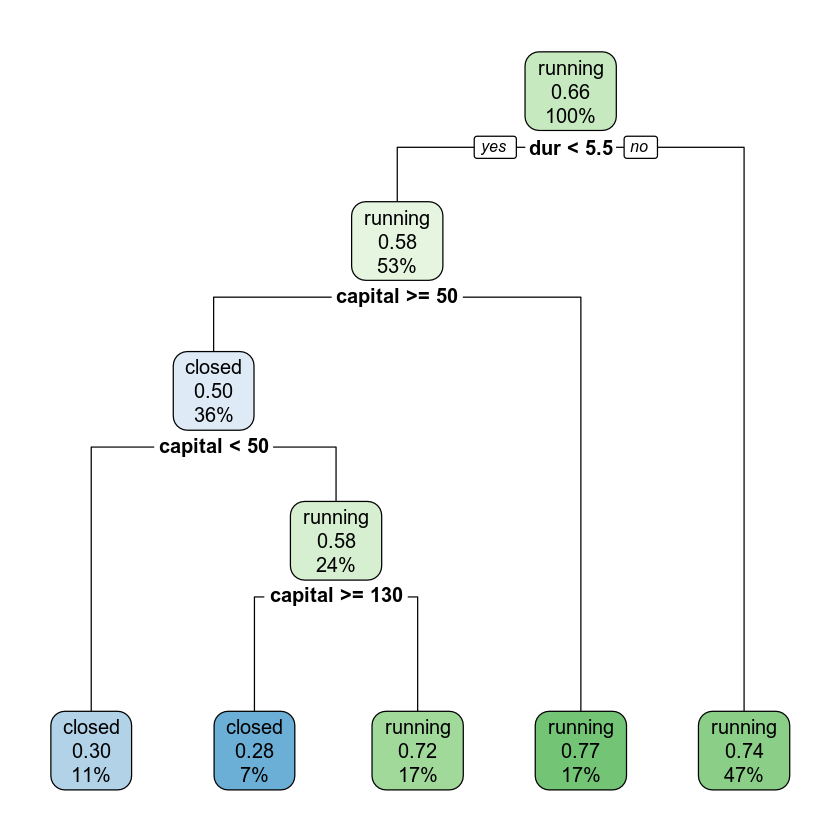

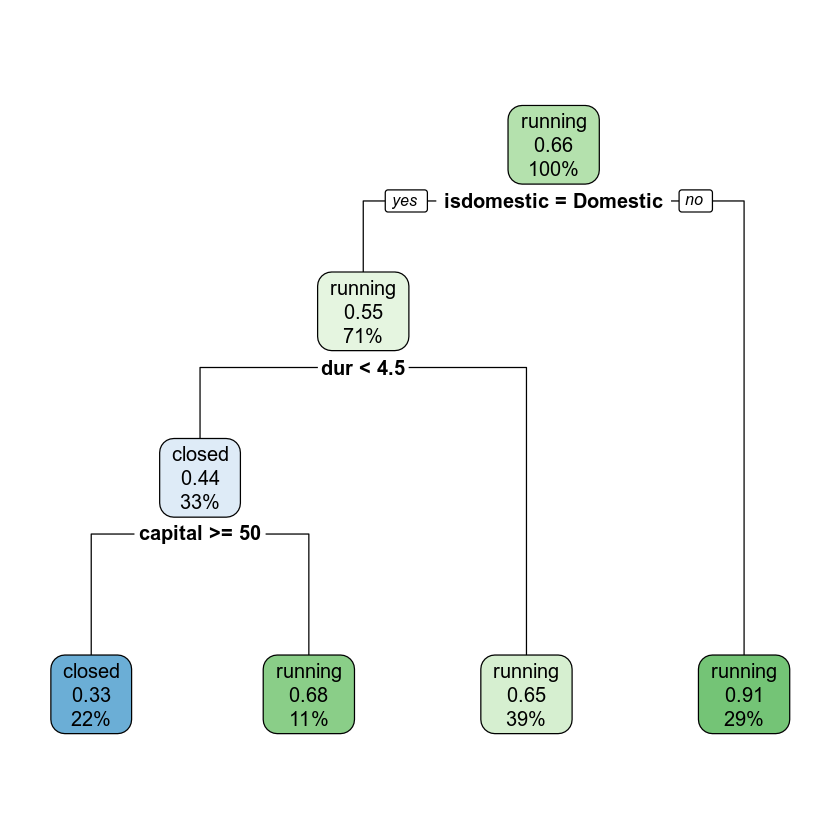

In [125]:
trip.part1 <- rpart(isclosed ~ capital + dur, data = trip.all, control = rpart.control(cp = 0.01))
bestcp <- trip.part1$cptable[which.min(trip.part1$cptable[,"xerror"]),"CP"]
trip.part1.b <- prune(trip.part1, bestcp) # pruning
rpart.plot(trip.part1.b)

## domestic?
trip.part1.1 <- rpart(isclosed ~ capital + dur + isdomestic, data = trip.all, control = rpart.control(cp = 0.01))
bestcp <- trip.part1.1$cptable[which.min(trip.part1.1$cptable[,"xerror"]),"CP"]
trip.part1.1.b <- prune(trip.part1.1, bestcp)
rpart.plot(trip.part1.1.b)

+ 나무의 모양이 판이해졌습니다. 특히 각 분기에서 사용되는 변수를 보면 더 이상 `capital`이 중요하지 않음을 알 수 있습니다. 당연하게도, 우리가 이미 `capital` 변수를 범주화 (정보량 감소)했기 때문입니다. 그나마 좀 더 명확해진 점은, '신생 대형 여행사'는 국내외를 막론하고 생존율이 25%에 불과하다는 사실입니다. 그러나 모델의 적절성은 해당 노드에 전체 레코드의 1%만 존재한다는 점에서 의문시됩니다.
+ 국내 여행사 여부를 넣으면, 가장 첫 번째 분기가 국내 여행사 여부로 선택되고, 상당한 모델의 향상이 관찰됩니다. 일단 해외 여행사는 91% 확률로 생존하는 것을 확인할 수 있으며, 나머지 여행사들은 존속 연수에 따라서만 분류됩니다. 안타깝게도 범주화된 `capital.big`은 네 번째 모델에서 선택되지 않았습니다. 이는 위 사례에서도 확인됩니다. 세 번째 모델 결과에서, `capital.big`은 가장 마지막 분기에서 등장했습니다. 이는 곧 `capital.big`이 분류에서 상대적으로 낮은 중요성을 갖는다는 사실을 방증합니다. 그런 이유로 해서 네 번째 모델에서는 제한된 복잡도에서 `capital.big`이 아예 이용되지 않은 것입니다.

In [7]:
quantile(trip.all$capital, 0.90)

90% 
150

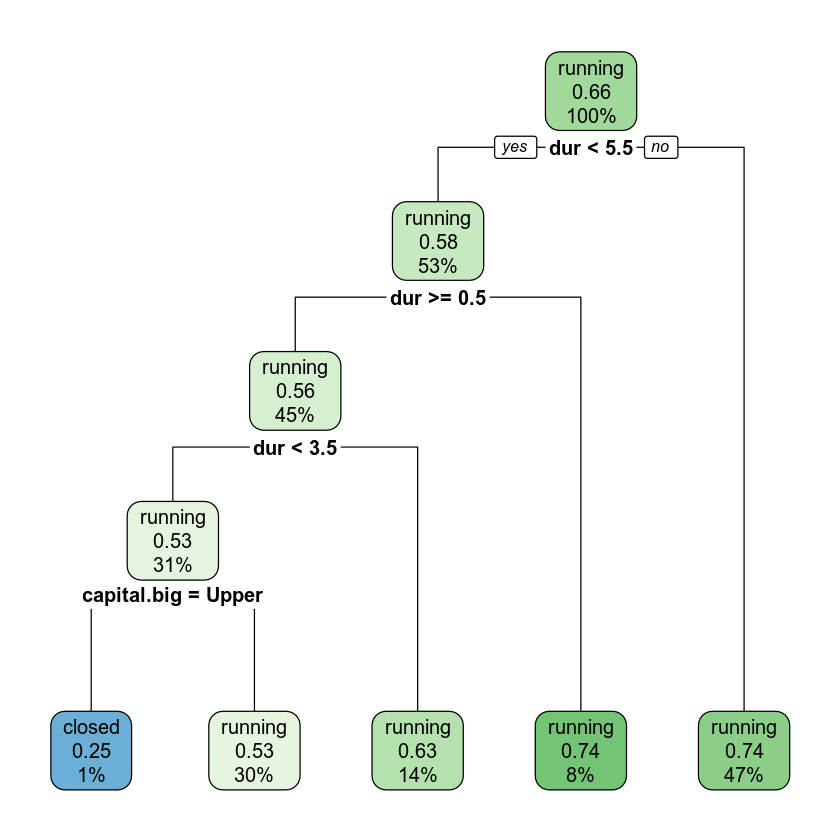

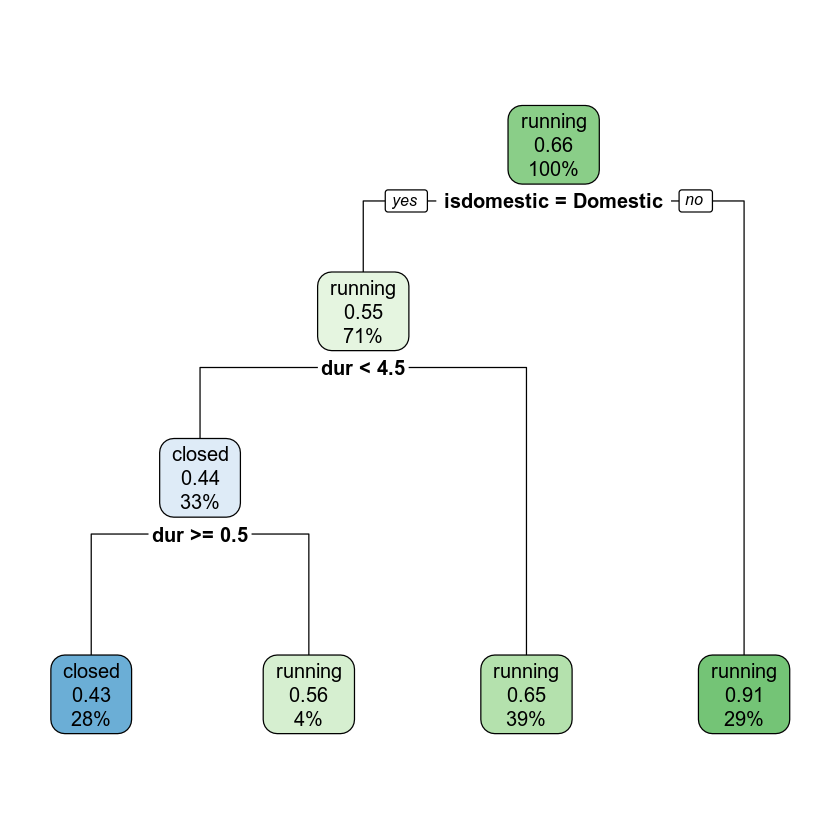

In [90]:
trip.part2 <- rpart(isclosed ~ capital.big + dur, data = trip.all, control = rpart.control(cp = 0.001))
bestcp <- trip.part2$cptable[which.min(trip.part2$cptable[,"xerror"]),"CP"]
trip.part2.b <- prune(trip.part2, bestcp)
rpart.plot(trip.part2.b)


trip.part2.1 <- rpart(isclosed ~ capital.big + dur + isdomestic, data = trip.all, control = rpart.control(cp = 0.001))
bestcp <- trip.part2.1$cptable[which.min(trip.part2.1$cptable[,"xerror"]),"CP"]
trip.part2.1.b <- prune(trip.part2.1, bestcp)
rpart.plot(trip.part2.1.b)

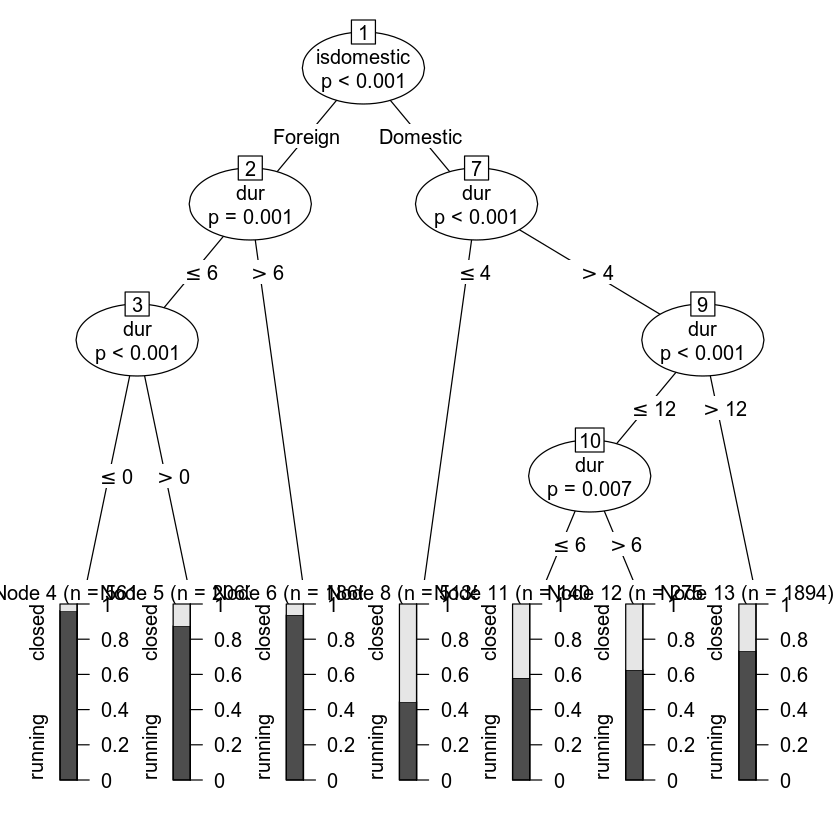

In [122]:
trip.party1 <- party::ctree(formula = isclosed ~ dur + isdomestic, data = trip.all, )
plot(trip.party1)

### Go predictive
+ 지금까지의 모델들은 모두 설명을 위한 모델인 셈입니다. 왜일까요?
+ 데이터를 나누어서 모델링해 봅시다. 과연 우리의 정확도는 얼마나 될는지를 확인하기 위함입니다.
+ training과 test 데이터를 만들기 위해서 우리가 배웠던 `dplyr`의 또다른 함수를 이용해 보았습니다. join의 여러가지 형태에 관해 생각해 보십시오.

In [95]:
trip.train <- trip.all %>% dplyr::sample_frac(.8)
trip.test  <- dplyr::anti_join(trip.all, trip.train, by = '도로명전체주소')
str(trip.train)
str(trip.test)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	12548 obs. of  19 variables:
 $ 도로명전체주소: chr  "충청북도 단양군 단양읍 별곡7길 3" "경기도 군포시 고산로148번길 17, B동 902호 (당정동, 군포IT밸리)" "대전광역시 유성구 도안대로 591, 208호 (봉명동, 명동프라자)" "부산광역시 금정구 식물원로 61-1 (장전동)" ...
 $ 인허가일자    : int  20180504 20160822 20130111 20070627 19990625 20070724 20120723 20130711 20070222 20020829 ...
 $ 영업상태명    : chr  "운영중" "운영중" "폐업 등" "운영중" ...
 $ 폐업일자      : int  NA NA 20180109 NA NA 20140128 NA NA NA NA ...
 $ 건축연면적    : int  NA NA NA NA NA NA NA NA NA NA ...
 $ 시설규모      : int  NA 17 NA 90 NA 401 NA 51 NA NA ...
 $ 자본금        : num  3.0e+07 3.0e+07 1.0e+08 1.5e+08 1.5e+08 1.5e+08 9.0e+07 3.0e+07 5.0e+07 1.0e+08 ...
 $ 위치정보(X)   : num  321959 195882 230589 389449 210760 ...
 $ 위치정보(Y)   : num  388237 427814 317286 193772 365398 ...
 $ class         : chr  "Foreign" "Foreign" "Domestic" "Domestic" ...
 $ sido          : chr  "충청북도" "경기도" "대전광역시" "부산광역시" ...
 $ startyr       : num  2018 2016 2013 2007 1999 ...
 $ endyr         : num  NA NA 2018 

+ `trip.part2.1` 모형에서 투입 데이터만 `trip.train`으로 바꾸었습니다.
+ 같은 모델 복잡도 하에서, 우리는 결과값을 '확률'로 얻습니다. 따라서 여기서는 'running'이 나올 확률이 0.5만 초과하면 'running'으로 판정되도록 했습니다.
+ 예측 정확도는 68.91%입니다만, 단일한 시행이므로 더 자세한 정확도는 여러 차례 데이터를 분할하여 평가하여야 합니다.

[1] 68.90794

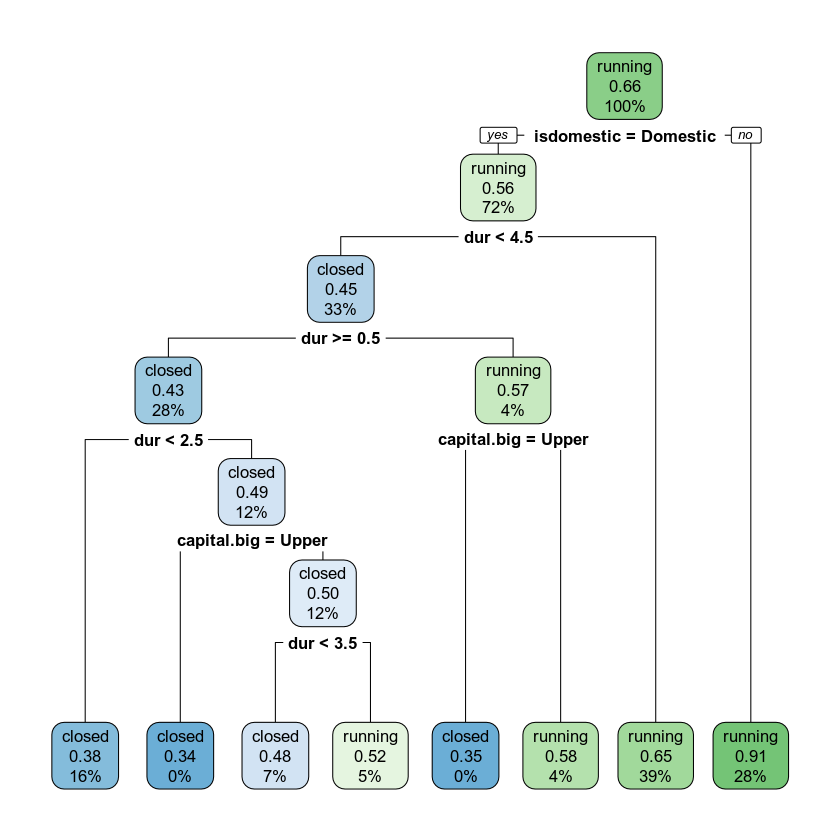

In [123]:
trip.part2.2 <- rpart(isclosed ~ capital.big + dur + isdomestic, data = trip.train, control = rpart.control(cp = 0.001))
bestcp <- trip.part2.2$cptable[which.min(trip.part2.2$cptable[,"xerror"]),"CP"]
trip.part2.2 <- prune(trip.part2.2, bestcp)

rpart.plot(trip.part2.2)

trip.part2.predict <- predict(trip.part2.2, trip.test)

trip.part2.predict <- trip.part2.predict %>%
    data.frame %>%
    mutate(result = if_else(running > 0.5, 'running', 'closed'))

sum(trip.part2.predict$result == trip.test$isclosed) / nrow(trip.test) * 100

### Strength and Weaknesses
+ CART는 상황에 따라서 매우 효율적이며, 모델의 흐름을 직관적인 시각화 자료로 나타낼 수 있다는 점에서 분명한 장점이 있습니다.
+ 그러나 약점을 꼭 알아두도록 합시다.
    + 데이터에 따른 __모델 불안정성__: 논리적으로 배반인 여러 조건들로 이루어진 나무는, 당연하게도 사용하는 데이터의 조건에 따라서 매우 불안정한 결과를 생성해낼 수 있습니다.
    + __예측성능이 최적이 아님(less-than-optimal)__: 위에서 보았듯이, 나무기반모형은 다차원 공간을 여러 선들(if-else 문들)로 양분해 가면서 예측을 수행합니다. 달리 말해서, 영역을 여러 직사각형들로 나누는 셈입니다. 그런데 이용하는 예측변수가 피예측변수와 단순한 직사각형 영역으로 나눌 수 있는 관계를 갖지 않는다면, 예측 성능은 매우 떨어지게 될 것입니다.
+ 위의 약점을 해소하기 위한 방법이 앙상블(ensemble) 기반의 Random Forest입니다.

## Tree ensemble
### Principles
+ 단일한 트리만으로는 충분한 예측성능을 얻어내기 어려울 수 있습니다. '예측'이 새로운 데이터에 대해 수행되는 것임에 유의하십시오.
+ 그렇다면, 우리가 생각할 수 있는 방안은 두 가지입니다.
    + 단일한 트리를 최대한 강화한 후 최종 의사결정한다.
    + 여러 트리를 동원해서 결과를 조합하여 최종 의사결정한다.
+ 첫 번째 방법은 boosted trees라 하는 방법인데, 이 곳에서는 다루지 않으려 합니다. 이번 장에서 다룰 내용이 바로 두 번째 내용, 즉 여러 트리를 동원하는 방법입니다.
+ 두 번째 방법 가운데서 오늘 소개할 내용은 bagged trees와 random forest입니다.

+ 들어가기 전에, '앙상블'의 방법에 관해 간단히 소개하겠습니다.
    + 앙상블 기법이란 말 그대로 여러 하위모델의 결과들을 종합하는 기법을 말합니다.
    + 그렇다면 '종합'을 어떻게 하는가? 연속형이라면 평균 또는 분포를 이용하여 대푯값을 계산하는 방법을, 범주형이라면 다수결(voting)하는 방법이 있습니다.

### Bagged Trees
+ Bag이라는 단어에 생소하실 지도 모르겠습니다. Bag은 Bagging에서 나온 말이며, Bagging은 Bootstrap Aggregating의 준말입니다. 즉, 데이터를 무작위하게 나누어서 적합시킨 모형에서 얻은 예측값을 종합하는 기법을 말합니다.
+ 아래 그림을 보십시오. 전체 데이터를 사용할 때의 나무(왼쪽 위)와 나머지 나무들이 모두 다른 형태를 하고 있습니다 (달리 말해서, 종말노드에서 각각 다른 예측값을 냅니다).
+ 우리는 이들 나무들에서 얻은 결과들을 종합해서 최종 결과를 얻을 수 있습니다. 
+ Bagging 기법은 일반적인 모델들에서도 성능을 향상시키는 데 왕왕 활용되므로 잘 익혀 두시면 유익할 것입니다.

![](https://images.slideplayer.com/35/10391576/slides/slide_20.jpg)

In [152]:
library(ipred)
form1 <- isclosed ~ dur + isdomestic + capital
form2 <- isclosed ~ dur + isdomestic + capital + isseoul
form3 <- isclosed ~ dur + isdomestic + capital.big
trip.bt1 <- ipred::bagging(formula = form1, data = trip.train, nbagg = 100, coob = TRUE)
trip.bt2 <- ipred::bagging(formula = form2, data = trip.train, nbagg = 100, coob = TRUE)
trip.bt3 <- ipred::bagging(formula = form3, data = trip.train, nbagg = 100, coob = TRUE)

+ 위 코드 블록에서는 `nbagg`, 즉 무작위 추출 횟수를 100회로 하였습니다.
+ `coob` 인수는 Out-Of-Bag-Error(OOB)를 계산할 것인가의 여부를 결정합니다. 이 개념은 Bagging에서 무작위 추출이 되지 않은 자료에 대해 예측한 정확도를 측정하기 위한 개념입니다. `TRUE`로 놓으면 error를 계산합니다.

In [153]:
100 * (1 - trip.bt1$err)
100 * (1 - trip.bt2$err)
100 * (1 - trip.bt3$err)

[1] 76.67357

[1] 76.23526

[1] 70.09085

+ 서울 여부(`trip.bt2`)는 크게 중요한 변수는 아니었던 것 같습니다.
+ 자본금의 정보를 압축한 결과는 -6%의 정확도 하락으로 돌아왔습니다.

### Random Forest
+ 이제 우리는 완전한 무작위의 세계에서 나무를 얻어냅니다. Random forest의 원리는 명칭에서 유추할 수 있듯이 데이터로부터 완전히 무작위하게 나무를 만들어 냅니다.
+ '무작위성'은 변수의 선택(분기를 할 변수는 무엇이 되어야 하는가)까지 미칩니다. 즉, 좀 더 복잡한 형태의 Bagged trees인 셈입니다. 여러 나무를 활용하여 결과를 산출하므로, 'Forest'라는 용어를 사용합니다.
+ 덧붙여서, 이 알고리즘은 연속형 변수에서 어느 값을 기준으로 규칙을 만들 것인가까지 무작위하게 만듭니다.
+ Random forest의 또다른 특징은, 기존 나무모형에서 모형의 복잡성이나 지나치게 세부화된 종말노드 등을 없애는 과정인 __가지치기(pruning)를 하지 않는다는 점__입니다. 따라서 과적합(overfitting)의 우려가 발생할 수 있는데, 이는 수많은 나무모형을 이용하여 방지할 수 있습니다.

![Pseudocode of Random Forest algorithm](https://www.cse.wustl.edu/~m.neumann/sp2016/cse517/lecturenotes/images/lec17/RF.png)

+ Random forest 모형의 적합에는 몇 가지 제한요소를 둘 수 있습니다.
    + 최대 몇 개의 나무모형을 이용할 것인가
    + 나무를 어디까지 기를 것인가 (분기를 몇 단계까지 허용할 것인가)
    + 최대 종말노드 개수는 몇 개가 되어야 하는가
    + 최소한 사용할 변수는 몇 개가 되어야 하는가 등이 있습니다.
+ `randomForest` 패키지에서 이 기법을 종합적으로 적용해볼 수 있습니다. 개별 모형을 시각화하여 전달하기에 어려운 모형입니다 (나무를 최소 100개 이상 사용한다는 점을 상기하십시오). 정확도 평가를 위한 '실전 상황'에서 적용해 봄직합니다.
+ 당연하게도, random forest 모형은 회귀분석이나 분류 문제 모두에 적용할 수 있습니다.



![](https://www.kdnuggets.com/wp-content/uploads/rand-forest-2.jpg)

In [127]:
trip.rf1 <- randomForest(formula = isclosed ~ dur + isdomestic + capital, data = data.frame(trip.all))

In [128]:
trip.rf1


Call:
 randomForest(formula = isclosed ~ dur + isdomestic + capital,      data = data.frame(trip.all)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 25.63%
Confusion matrix:
        closed running class.error
closed    2247    3134  0.58241962
running    886    9418  0.08598602

In [130]:
varImp(trip.rf1)

,Overall
dur,328.7403
isdomestic,737.2158
capital,390.1476


In [137]:
trip.rf.train <- randomForest(formula = isclosed ~ dur + isdomestic + capital, data = data.frame(trip.train))
trip.rf.pred <- predict(trip.rf.train, trip.test)
varImp(trip.rf.train)

,Overall
dur,270.6658
isdomestic,564.1496
capital,341.7154


+ 큰 향상이 아닐지 모르나, 예측정확도가 약 5% 상승했음을 확인할 수 있습니다.
+ 비교적 단순한 3개 변수를 사용했다는 점을 상기하십시오!

In [134]:
sum(trip.rf.pred == trip.test$isclosed)/nrow(trip.test) * 100

[1] 73.60108

+ 시험삼아 서울 여부를 포함해 보면 어떨까요?
+ 정확도는 3% 정도 높아졌는데, 주목할 만한 점은 변수의 중요도가 달라졌다는 점입니다. 위에서 서울 여부가 포함되지 않았을 때에는 국내여행사 여부가 가장 큰 중요도를 나타냈습니다.
+ 그러나 서울 여부가 들어가자 '자본금'이 가장 중요하게 되었습니다.

In [135]:
trip.rf.train.1 <- randomForest(formula = isclosed ~ dur + isdomestic + capital + isseoul, data = data.frame(trip.train))
trip.rf.pred.1 <- predict(trip.rf.train.1, trip.test)
varImp(trip.rf.train.1)

,Overall
dur,462.55107
isdomestic,619.53403
capital,697.90076
isseoul,61.51378


In [136]:
sum(trip.rf.pred.1 == trip.test$isclosed)/nrow(trip.test) * 100

[1] 76.66968

## 기타 알고리즘
+ C5.0
+ Cubist

## Assignment
+ (배경지식) 2009년 이전 상법상 최소 자본금이 5천만원이라고 한다. 이 점을 고려하여, 첫 번째 모델을 개업 연도에 따라 2009년 이전과 2010년 이후로 나누어서 모델링하고, 그 결과를 도시한 뒤, 결과를 간단히 요약하라. (3분 이내)
+ `trip.part.2.2`모델을 기반으로 하여, 서로 다른 training data와 test data를 100회 생성하여 정확도를 측정하시오. 그리고 측정 결과를 요약하시오.
+ Challenge
    + [지방자치단체별 인허가정보](http://localdata.kr)에 접속하여 업종 한 곳과 지역(시도) 두 곳을 정하여 자료를 내려받으시오. (폐업내역이 포함된 '전체 데이터'를 내려받으시오)
    + 위에 제공된 코드들을 참고하여 자료를 모델에 투입할 수 있도록 전처리하시오.
    + CART나 Ensembled tree로 위의 요령으로 개폐업 분석을 실시하고, 결과를 간단히 요약하여 5분 이내로 발표하시오.